<a href="https://colab.research.google.com/github/renatovfreitas/DataCircle_Twitter_Project/blob/Diego_ML/twitter_roberta_base_sentiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
from transformers import AutoModelForSequenceClassification, AutoTokenizer#
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import urllib.request
import csv
import nltk
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ten_thousand_tweets.csv to ten_thousand_tweets.csv


In [ ]:
df = pd.read_csv("ten_thousand_tweets.csv")
print(df.head(3))
# Clean column names
df.columns = df.columns.str.strip()
# Check the cleaned column names
print(df.columns.tolist())

            created_at             tweet_id  likes  retweet_count  \
0  2020-11-02 19:33:16  1323347462157967360      0              0   
1  2020-11-03 02:10:22  1323447396043525888      1              0   
2  2020-10-24 17:16:49  1320051631673716736      8              5   

               source              user_id       user_join_date  \
0  twitter for iphone  1155671810547093504  2019-07-29 02:50:05   
1     twitter web app   862434477758451712  2017-05-10 22:29:37   
2  twitter for iphone  1239182155240144896  2020-03-15 13:30:38   

   user_followers_count               user_location    city        country  \
0                    35                florida, usa  unkown  united states   
1                    61                 endwell, ny  unkown         unkown   
2                  3182  sorry for google translate  unkown         unkown   

     state candidate                                      tweet_cleaned  
0  florida     biden  maggieann1222 icecube lol #biden labeled blac

In [ ]:
def process_tweet(tweet):
    tweet = re.sub(r'\$\w*', '', tweet)  # Remove dollar signs and words following them
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)  # Remove URLs
    tweet = re.sub(r'#', '', tweet)  # Remove hash symbol
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    stopwords_english = stopwords.words('english')
    stemmer = PorterStemmer()
    tweets_stem = []

    #for word in tweet_tokens:
     #   if word not in stopwords_english and word not in string.punctuation:
      #      stem_word = stemmer.stem(word)
       #     tweets_stem.append(stem_word)

    return tweets_stem

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
df['processed_tweets'] = df['tweet_cleaned'].apply(preprocess)
print(df[['tweet_cleaned', 'processed_tweets']].head(5))

                                       tweet_cleaned  \
0  maggieann1222 icecube lol #biden labeled black...   
1  inspired #biden crowd holy shit please #vote #...   
2  rudygiuliani #hunterbiden admitting via text h...   
3  realdonaldtrump seanparnellusa thejusticedept ...   
4  although #biden win wouldnt upend decadeslong ...   

                                    processed_tweets  
0  maggieann1222 icecube lol #biden labeled black...  
1  inspired #biden crowd holy shit please #vote #...  
2  rudygiuliani #hunterbiden admitting via text h...  
3  realdonaldtrump seanparnellusa thejusticedept ...  
4  although #biden win wouldnt upend decadeslong ...  


In [ ]:
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
print(df.columns)
print(df['processed_tweets'])

Index(['created_at', 'tweet_id', 'likes', 'retweet_count', 'source', 'user_id',
       'user_join_date', 'user_followers_count', 'user_location', 'city',
       'country', 'state', 'candidate', 'tweet_cleaned', 'processed_tweets'],
      dtype='object')
0       maggieann1222 icecube lol #biden labeled black...
1       inspired #biden crowd holy shit please #vote #...
2       rudygiuliani #hunterbiden admitting via text h...
3       realdonaldtrump seanparnellusa thejusticedept ...
4       although #biden win wouldnt upend decadeslong ...
                              ...                        
9995    #berniebros responsible #scotussham theyre tru...
9996    apologize advance barrage tweets today im prob...
9997    realdonaldtrump courts yes packed google insan...
9998                      hes yelling hes old #trump 2020
9999               #electionresults2020 #trump #trump2020
Name: processed_tweets, Length: 10000, dtype: object


In [ ]:
labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

In [ ]:
print(df.columns)
print(df.shape)

Index(['created_at', 'tweet_id', 'likes', 'retweet_count', 'source', 'user_id',
       'user_join_date', 'user_followers_count', 'user_location', 'city',
       'country', 'state', 'candidate', 'tweet_cleaned', 'processed_tweets'],
      dtype='object')
(10000, 15)


In [ ]:
# Prepare to store results
results = []

for text in df['processed_tweets']:
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # Get the ranking of the scores
    ranking = np.argsort(scores)[::-1]  # Sort scores in descending order
    sentiment = {labels[i]: np.round(float(scores[i]), 4) for i in ranking}
    results.append(sentiment)

# Convert results to a DataFrame
sentiment_df = pd.DataFrame(results)

# Concatenate the original DataFrame with the sentiment results
final_df = pd.concat([df, sentiment_df], axis=1)

In [ ]:
# Sentiment polarity function
def get_polarity(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    return polarity

# Apply sentiment polarity function to the DataFrame
df['polarity'] = df['tweet_cleaned'].apply(get_polarity)

In [ ]:
# Subjectivity function
def get_subjectivity(text):
    analysis = TextBlob(text)
    if analysis.sentiment.subjectivity < 0.5:
        subjectivity = 'objective'
    else:
        subjectivity = 'subjective'

    return subjectivity

# Apply subjectivity function to the DataFrame
df['subjectivity'] = df['tweet_cleaned'].apply(get_subjectivity)

# Create a column for Sentiment analysis
df['sentiment'] = df['polarity'].apply(lambda i: 'positive' if i > 0 else ('neutral' if i == 0 else 'negative'))

In [ ]:
def get_predicted_sentiment(row):
    if row['positive'] > row['negative'] and row['positive'] > row['neutral']:
        return 'positive'
    elif row['negative'] > row['positive'] and row['negative'] > row['neutral']:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to get predicted sentiments
final_df['predicted_sentiment'] = final_df.apply(get_predicted_sentiment, axis=1)

In [ ]:
print(final_df.columns)
print(final_df.shape)

Index(['created_at', 'tweet_id', 'likes', 'retweet_count', 'source', 'user_id',
       'user_join_date', 'user_followers_count', 'user_location', 'city',
       'country', 'state', 'candidate', 'tweet_cleaned', 'processed_tweets',
       'neutral', 'negative', 'positive', 'predicted_sentiment'],
      dtype='object')
(10000, 19)


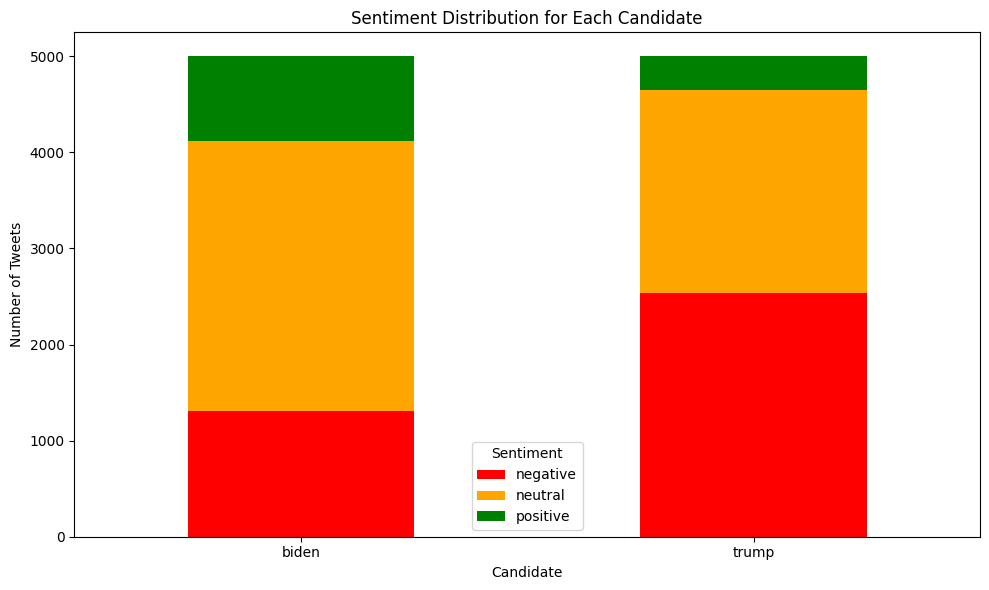

In [ ]:
# Count the occurrences of each sentiment for each candidate
sentiment_counts = final_df.groupby(['candidate', 'predicted_sentiment']).size().unstack(fill_value=0)
# Define colors for each sentiment
colors = ['red', 'orange', 'green']

# Plotting the bar chart
sentiment_counts.plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))

# Adding labels and title
plt.title('Sentiment Distribution for Each Candidate')
plt.xlabel('Candidate')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Sentiment')
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [ ]:
candidate_counts = final_df['candidate'].value_counts()

# Print counts for Trump and Biden
trump_count = candidate_counts.get('trump', 0)  # Default to 0 if 'trump' is not found
biden_count = candidate_counts.get('biden', 0)  # Default to 0 if 'biden' is not found

print(f"Trump: {trump_count} times")
print(f"Biden: {biden_count} times")

Trump: 5000 times
Biden: 5000 times


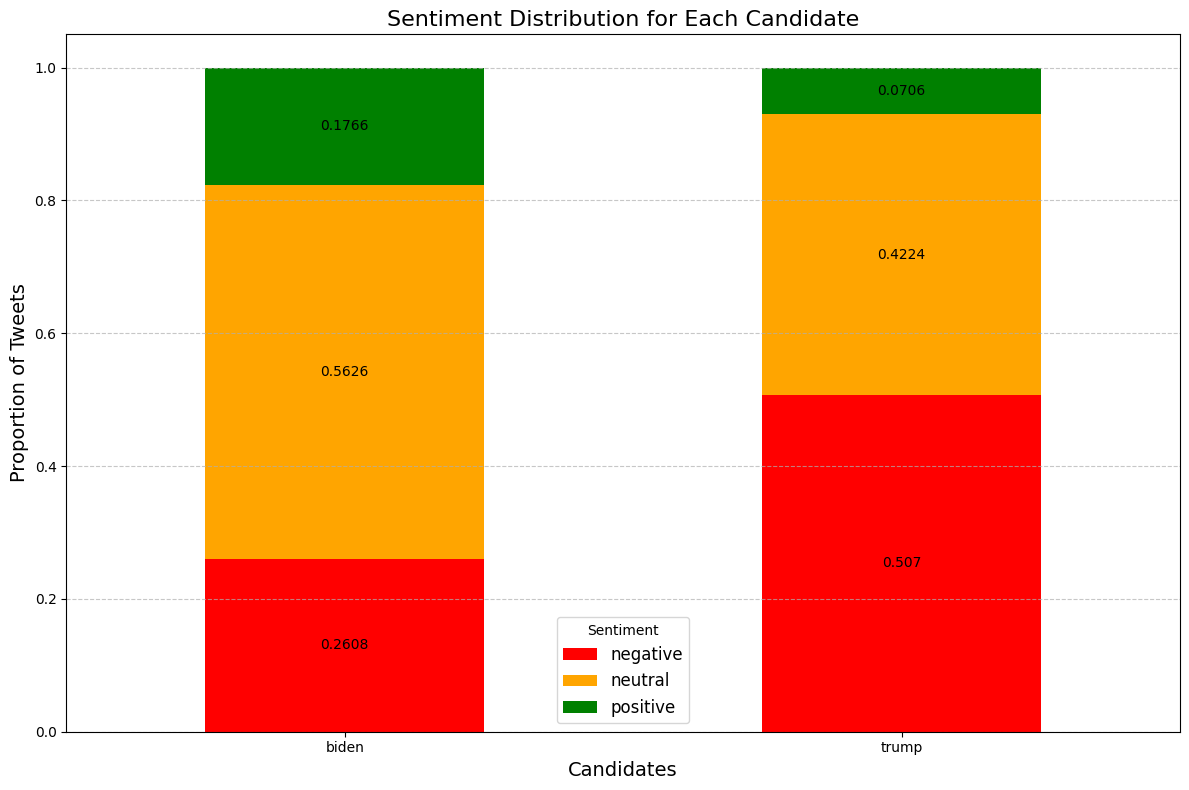

In [ ]:
# Calculate proportions
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Plotting the bar chart
ax = sentiment_proportions.plot(kind='bar', stacked=True, color=colors, figsize=(12, 8))

# Adding labels and title
plt.title('Sentiment Distribution for Each Candidate', fontsize=16)
plt.xlabel('Candidates', fontsize=14)
plt.ylabel('Proportion of Tweets', fontsize=14)
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Sentiment', fontsize=12)

# Adding data labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=10)

plt.tight_layout()  # Adjust layout to make room for the legend
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add gridlines for better readability
plt.show()